Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

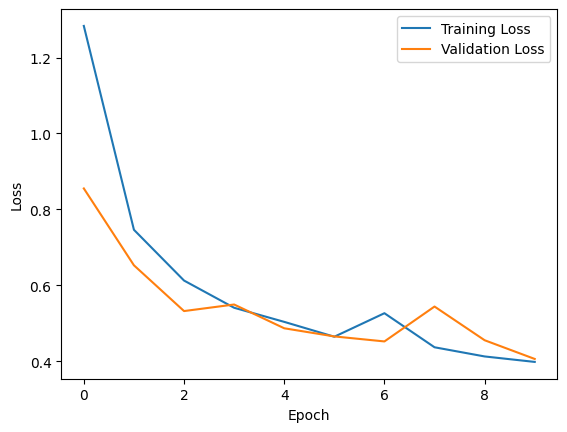

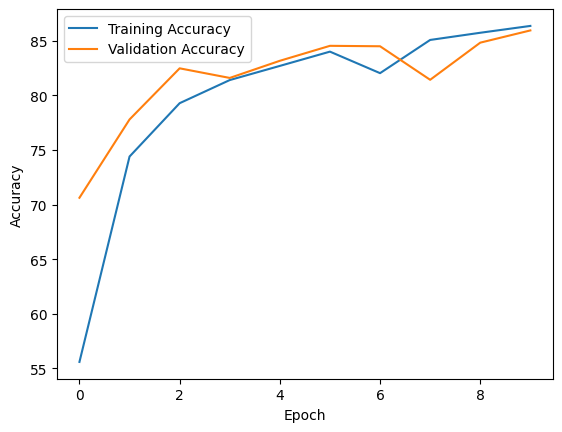

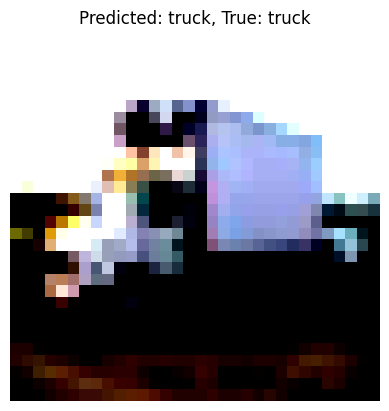

Predicted label:  truck
Actual label:  truck


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time

def load_dataset():
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    total_training_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds\n')

        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'classes': classes
            }
            torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    print(f'Total training time: {total_training_time:.2f} seconds')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

def plot_image(dataset, model, classes):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    img = img.squeeze().permute(1, 2, 0).cpu()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

if __name__ == '__main__':
    train_model = True

    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    num_classes = 10

    model = models.resnet50(pretrained=True)
    print("Network before modifying conv1:")
    print(model)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    print("Network after modifying conv1:")
    print(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
        num_epochs = 10
        save_interval = 5
        model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
            model, trainloader, testloader, criterion, optimizer, device,
            num_epochs, save_interval)

        torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

        plot_loss(train_losses, test_losses)
        plot_accuracy(train_accuracies, test_accuracies)
    else:
        model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
        checkpoint = torch.load("resnet50_cifar10_variables.pth")
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        classes = checkpoint['classes']
        model.to(device)
        model.eval()

    plot_image(testset, model, classes)